**Transfer Learning Project**

Goal of this project is to build an end of end deep learning project using transfer learning

The project uses a pre-trained model- Resnet50 as the baseline. It then uses transfer learning to train the model on a public database of birds and builds a final model that can classify an image as bird or a non bird image

The project uses data from Caltech birds dataets and other publicly available data sets. Projet has been buit on Google colab to avoid limitations running on a regular CPU/GPU on local netbooks.



In [ ]:
from pathlib import Path
import numpy as np
import joblib
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import joblib
from keras.models import model_from_json
from pathlib import Path
from keras.preprocessing import image
import numpy as np
from keras.applications import resnet50

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Starting with an example of the ResNet50 model and tried it out an test image captured during  trip to the beaach

In [ ]:
# Load Resnet50 model that was pre-trained against the ImageNet database
model = resnet50.ResNet50()
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# Load the image file, resizing it to 224x224 pixels (required by this model)
imageFile = "/content/drive/My Drive/Colab Notebooks/Seaside.jpg"
img = image.load_img(imageFile, target_size=(224, 224))

In [ ]:
# Convert the image to a numpy array
x = image.img_to_array(img)
# Add a fourth dimension (since Keras expects a list of images)
x = np.expand_dims(x, axis=0)
# Normalize the input image's pixel values to the range used when training the neural network
x = resnet50.preprocess_input(x)
# Run the image through the deep neural network to make a prediction
predictions = model.predict(x)


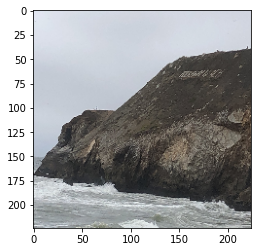

Top predictions for this image:
Prediction: promontory - 0.985198
Prediction: seashore - 0.007877
Prediction: cliff - 0.005546
Prediction: beacon - 0.000386
Prediction: sandbar - 0.000378


In [ ]:
# Look up the names of the predicted classes. Index zero is the results for the first image.
predicted_classes = resnet50.decode_predictions(predictions)
# Draw the image as a plot
plt.imshow(img)
    
# Show the plot on the screen
plt.show()

print("Top predictions for this image:")

for imagenet_id, name, likelihood in predicted_classes[0]:
    print("Prediction: {} - {:2f}".format(name, likelihood))

Used the Caltech birds database that has over 200 species of bird images in a collection of over 6000 images
Used a subset of 1000 images to avoid limitations on runtime memory

In [ ]:
# Path to folders with training data
bird_path = Path("/content/drive/My Drive/Colab Notebooks/training_data") / "birds"
not_bird_path = Path("/content/drive/My Drive/Colab Notebooks/training_data") / "nobirds"
images = []
labels = []


In [ ]:
# Load all the not-bird images
count =0
for img in not_bird_path.glob("*.jpg"):
    count = count+1
    # Load the image from disk
    #print ("img ", img)
    img = image.load_img(img, target_size=(224, 224))

    # Convert the image to a numpy array
    image_array = image.img_to_array(img)

    # Add the image to the list of images
    images.append(image_array)

    # For each 'not bird' image, the expected value should be 0
    labels.append(0)

print("Total non bird images loaded: ", count)

Total non bird images loaded:  808


In [ ]:
# Load all the bird images
count_bird = 0
for img in bird_path.glob("*.jpg"):
    # Load the image from disk
    #print ("img ", img)
    count_bird = count_bird + 1
    img = image.load_img(img, target_size=(224, 224))
    # Convert the image to a numpy array
    image_array = image.img_to_array(img)

    # Add the image to the list of images
    images.append(image_array)

    # For each 'bird' image, the expected value should be 1
    labels.append(1)

print("Total bird images loaded: ", count_bird)

Total bird images loaded:  1000


In [ ]:
# Create a single numpy array with all the images we loaded
x_train = np.array(images)

# Also convert the labels to a numpy array
y_train = np.array(labels)

In [ ]:
# Normalize image data to 0-to-1 range
x_train = resnet50.preprocess_input(x_train)
# Load a pre-trained neural network to use as a feature extractor
pretrained_nn = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#print("after loading model")
# Extract features for each image (all in one pass)
features_x = pretrained_nn.predict(x_train)

**Saving the features extracted from the Resnet50 model**

In [ ]:
# Save the array of extracted features to a file
joblib.dump(features_x, "x_train.dat")

# Save the matching array of expected values to a file
joblib.dump(y_train, "y_train.dat")

['y_train.dat']

In [ ]:
# Load data set
x_train = joblib.load("x_train.dat")
y_train = joblib.load("y_train.dat")


**Building a neural network model**

In [ ]:
# Create a model and add layers
model = Sequential()

model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 25,690,625
Trainable params: 25,690,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=['accuracy']
)

# Train the model
model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size = 50,
    shuffle=True
)

Epoch 1/10
37/37 [==============================] - 1s 26ms/step - loss: 1.6228 - accuracy: 0.9530
Epoch 2/10
37/37 [==============================] - 1s 24ms/step - loss: 0.1401 - accuracy: 0.9950
Epoch 3/10
37/37 [==============================] - 1s 24ms/step - loss: 0.0941 - accuracy: 0.9972
Epoch 4/10
37/37 [==============================] - 1s 24ms/step - loss: 0.0026 - accuracy: 0.9989
Epoch 5/10
37/37 [==============================] - 1s 24ms/step - loss: 0.0211 - accuracy: 0.9994
Epoch 6/10
37/37 [==============================] - 1s 25ms/step - loss: 0.0597 - accuracy: 0.9983
Epoch 7/10
37/37 [==============================] - 1s 23ms/step - loss: 0.0134 - accuracy: 0.9983
Epoch 8/10
37/37 [==============================] - 1s 24ms/step - loss: 0.0301 - accuracy: 0.9983
Epoch 9/10
37/37 [==============================] - 1s 24ms/step - loss: 0.0314 - accuracy: 0.9983
Epoch 10/10
37/37 [==============================] - 1s 24ms/step - loss: 0.0012 - accuracy: 0.9994


**Saving the newly created model and weights**

In [ ]:
# Save neural network structure
model_structure = model.to_json()
f = Path("model_structure.json")
f.write_text(model_structure)

# Save neural network's trained weights
model.save_weights("model_weights.h5")

In [ ]:
# Load the json file that contains the model's structure
f = Path("model_structure.json")
model_structure = f.read_text()

# Recreate the Keras model object from the json data
model = model_from_json(model_structure)

# Re-load the model's trained weights
model.load_weights("model_weights.h5")


Testing model on a bird image

In [ ]:
# Load an image file to test, resizing it to 64x64 pixels (as required by this model)
img = image.load_img("/content/drive/My Drive/Colab Notebooks/bird.jpg", target_size=(224, 224))

# Convert the image to a numpy array
image_array = image.img_to_array(img)

# Add a forth dimension to the image (since Keras expects a bunch of images, not a single image)
images = np.expand_dims(image_array, axis=0)

In [ ]:
# Normalize the data
images = resnet50.preprocess_input(images)

# Use the pre-trained neural network to extract features from our test image (the same way we did to train the model)
feature_extraction_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
features = feature_extraction_model.predict(images)


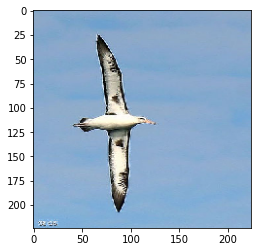

Likelihood that this image contains a bird: 100%


In [ ]:
# Given the extracted features, make a final prediction using our own model
results = model.predict(features)

# Since we are only testing one image with possible class, we only need to check the first result's first element
single_result = results[0][0]
# Draw the image as a plot
plt.imshow(img)
    
# Show the plot on the screen
plt.show()

# Print the result
print("Likelihood that this image contains a bird: {}%".format(int(single_result * 100)))

**Testing on another bird image**

In [ ]:
# Load an image file to test, resizing it to 64x64 pixels (as required by this model)
img = image.load_img("/content/drive/My Drive/Colab Notebooks/IMG_8040.jpg", target_size=(224, 224))

# Convert the image to a numpy array
image_array = image.img_to_array(img)

# Add a forth dimension to the image (since Keras expects a bunch of images, not a single image)
images = np.expand_dims(image_array, axis=0)

In [ ]:
# Normalize the data
images = resnet50.preprocess_input(images)

# Use the pre-trained neural network to extract features from our test image (the same way we did to train the model)
feature_extraction_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
features = feature_extraction_model.predict(images)


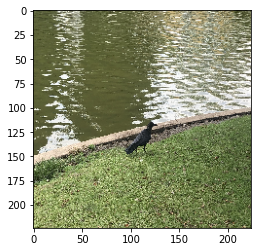

Likelihood that this image contains a bird: 100%


In [ ]:
# Given the extracted features, make a final prediction using our own model
results = model.predict(features)

# Since we are only testing one image with possible class, we only need to check the first result's first element
single_result = results[0][0]
# Draw the image as a plot
plt.imshow(img)
    
# Show the plot on the screen
plt.show()

# Print the result
print("Likelihood that this image contains a bird: {}%".format(int(single_result * 100)))

**Testing the model on a non bird image**

In [ ]:
# Load an image file to test, resizing it to 64x64 pixels (as required by this model)
img = image.load_img("/content/drive/My Drive/Colab Notebooks/Road.jpg", target_size=(224, 224))

# Convert the image to a numpy array
image_array = image.img_to_array(img)

# Add a forth dimension to the image (since Keras expects a bunch of images, not a single image)
images = np.expand_dims(image_array, axis=0)

In [ ]:
# Normalize the data
images = resnet50.preprocess_input(images)

# Use the pre-trained neural network to extract features from our test image (the same way we did to train the model)
feature_extraction_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
features = feature_extraction_model.predict(images)


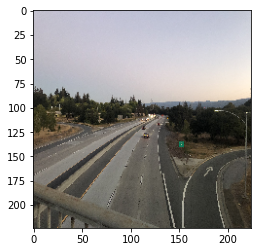

Likelihood that this image contains a bird: 0%


In [ ]:
# Given the extracted features, make a final prediction using our own model
results = model.predict(features)

# Since we are only testing one image with possible class, we only need to check the first result's first element
single_result = results[0][0]
# Draw the image as a plot
plt.imshow(img)
    
# Show the plot on the screen
plt.show()

# Print the result
print("Likelihood that this image contains a bird: {}%".format(int(single_result * 100)))